In [14]:
from thresholdExtractionPranav import ThresholdExtraction
import matplotlib.pyplot as plt
import numpy as np

In [15]:
import sys
sys.argv = ['tx', '-n', 'thresh_cross_4', '-i', '192.168.30.6', '-p', '27263']

params = {'log': 'INFO',
 'pack_per_call': 1,
 'thresh_mult': -4.5,
 'thresh_calc_len': 2000,
 'butter_lowercut': 250,
 'butter_uppercut': None,
 'butter_order': 4,
 'enable_CAR': False,
 'output_filtered': False,
 'acausal_filter_lag': 120,
 'acausal_filter': 'IIR',
 'input_name': 'reref_neural',
 'input_chan_per_stream': 256,
 'input_samp_per_stream': 30,
 'input_samp_freq': 30000,
 'input_data_type': 'float32',
 'use_tracking_id': True,
 'timestamp_data_type': 'uint64',
 'sync_key': 'sync',
 'time_key': 'ts',
 'sync_source_id': 'nsp_idx_1',
 'thresholds_stream': 'thresholds',
 'neural_ch_range': [0, 96],
 'thresholds_ch_range': [0, 96],
 'n_channels': 96,
 'ch_mask_stream': 'z_mask_stream'}

node = ThresholdExtraction(params)

[thresh_cross_4] INFO: Loading 4 order, 250 hz highpass acausal IIR-IIR filter
[thresh_cross_4] INFO: Loaded thresholds from the thresholds stream


[thresh_cross_4] Redis connection established on host: 192.168.30.6, port: 27263


In [16]:
node.run()


Timing Statistics (in milliseconds):
--------------------------------------------------------------------------------
Operation                            Mean        Min        Max      Count
--------------------------------------------------------------------------------
INIT                                1.731      1.731      1.731          1
INIT time                           0.315      0.315      0.315          1
Redis read                          0.796      0.048      4.717      14360
Data parsing                        0.010      0.008      0.470      14360
Filtering                           0.121      0.110      1.435      14360
Buffer updates                      0.001      0.001      0.224      14360
Threshold detection                 0.021      0.017      0.473      14356
Redis pipeline                      0.048      0.042      0.312      14356
Threshold Extraction                0.999      0.232      5.051      14356
Threshold Extraction2               1.000      0.2

KeyboardInterrupt: 

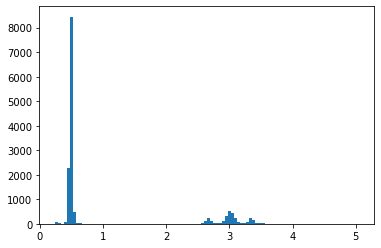

In [17]:


_=plt.hist(np.array(node.profiler.timings["Threshold Extraction3"])*1000,100)

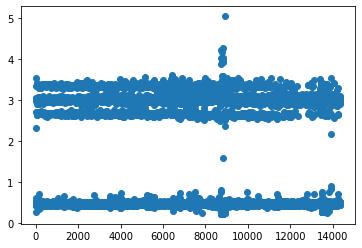

In [20]:
y = np.array(node.profiler.timings["Threshold Extraction3"])*1000
x=np.arange(len(y))
plt.scatter(x,y)

In [10]:
import time

start = time.perf_counter()
time.sleep(0.004)  # This is more precise than other sleep methods
elapsed = time.perf_counter() - start
print(f"Elapsed time: {elapsed:.6f} seconds")

Elapsed time: 0.004270 seconds


#filter test 

In [ ]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

def generate_test_signal(n_samples, fs):
    """Generate a test signal with known frequency components."""
    t = np.arange(n_samples) / fs
    # Create a signal with multiple frequency components
    signal = (
        np.sin(2 * np.pi * 10 * t) +  # 10 Hz component
        0.5 * np.sin(2 * np.pi * 30 * t) +  # 30 Hz component
        0.25 * np.sin(2 * np.pi * 50 * t)   # 50 Hz component
    )
    return signal

def acausal_filter(data,
                    filt_data,
                    rev_buffer,
                    sos,
                    zi,
                    group_list,
                    rev_win=None,
                    rev_zi=None,
                    n=0):
    """
    acausal filtering

    Parameters
    ----------
    data : array_like
        An N-dimensional input array.
    filt_data : ndarray
        Array to store the output of the digital filter.
    rev_buffer : ndarray
        Array to store the output of the forward IIR filter.
    sos : array_like
        Array of second-order filter coefficients
    zi : array_like
        Initial conditions for the cascaded filter delays
    group_list : list
        List of lists of channels grouped together across
        which to compute a common average reference
    rev_win : array-like, optional
        Coefficients of the reverse FIR filter
    rev_zi : array-like, optional
        Steady-state conditions of the reverse filter
    """
    # if False:
    #     common_average_reference(data, group_list)

    # shift the buffer
    n_samp = data.shape[1]
    rev_buffer[:, :-n_samp] = rev_buffer[:, n_samp:]

    # run the forward pass filter
    rev_buffer[:, -n_samp:], zi[:, :] = scipy.signal.sosfilt(sos,
                                                                data,
                                                                axis=1,
                                                                zi=zi)
    # run the backward pass filter
    # 1. pass in the reversed buffer
    # 2. get the last N samples of the filter output
    # 3. reverse the output when saving to filt_data
    if False:
        for ii in range(filt_data.shape[0]):
            filt_data[ii, ::-1] = np.convolve(rev_buffer[ii, ::-1],
                                                rev_win, 'valid')
    else:
        ic = rev_zi * filt_data[:, -1][None, :, None]
        filt_data[:, ::-1] = scipy.signal.sosfilt(sos,
                                                    rev_buffer[:, ::-1],
                                                    axis=1,
                                                    zi=ic)[0][:, -n_samp*():]

def build_filter():
    # order of the butterworth filter
    but_order = 4
    # lower cutoff frequency
    but_low = 250
    # upper cutoff frequency
    # whether to use an FIR filter on the reverse-pass
    acausal_filter = "IIR"
    # enable causal filtering
    causal = not acausal_filter
    # sampling rate of the input
    fs = 30000
    n_channels=256
    demean = False

    acausal_filter_lag = 120
    filt_type = 'highpass'
    Wn = but_low

    # set up filter
    sos = scipy.signal.butter(but_order,
                                Wn,
                                btype=filt_type,
                                analog=False,
                                output='sos',
                                fs=fs)  # set up a filter
    # initialize the state of the filter
    zi_flat = scipy.signal.sosfilt_zi(sos)
    # so that we have the right number of dimensions
    zi = np.zeros((zi_flat.shape[0], n_channels, zi_flat.shape[1]))
    # filter initialization
    for ii in range(n_channels):
        zi[:, ii, :] = zi_flat

    # select the filtering function
    use_fir = False
    filter_func = acausal_filter
    # log the filter info
    causal_str = 'causal' if causal else 'acausal'
    message = (f'Loading {but_order :d} order, '
                f'{Wn} hz {filt_type} {causal_str}')
    if causal:
        message += ' IIR filter'
    elif use_fir:
        message += ' IIR-FIR filter'
    else:
        message += ' IIR-IIR filter'
    message += ' with CAR' if demean else ''


    if not causal:
        if use_fir:
            # FIR filter (backward)
            N = acausal_filter_lag + 1  # length of the filter
            imp = scipy.signal.unit_impulse(N)
            rev_win = scipy.signal.sosfilt(sos, imp)
            # filter initialization
            rev_zi_flat = scipy.signal.lfilter_zi(rev_win, 1.0)
            rev_zi = np.zeros((n_channels, rev_zi_flat.shape[0]))
            for ii in range(n_channels):
                rev_zi[ii, :] = rev_zi_flat
        else:
            rev_win = None
            rev_zi = zi.copy()

    if causal:
        return filter_func, sos, zi
    else:
        return filter_func, sos, zi, rev_win, rev_zi


# Example usage
# test_params = {
#     'input_samp_freq': 1000,
#     'butter_order': 4,
#     'butter_lowercut': 5,
#     'butter_uppercut': 40
# }

# # Create the test
# fig = test_filter_artifacts(acausal_filter, test_params)
# plt.show()

In [108]:
(filter_func, sos, zi, rev_win,
    rev_zi) = build_filter()

n_channels = 256
n_samp = 30
data_buffer = np.zeros((n_channels, n_samp), dtype=np.float32)
data_buffer[0] = np.sin(np.linspace(0, 4*np.pi, n_samp))*10
filt_buffer = np.zeros_like(data_buffer)
rev_buffer = np.zeros(
    (n_channels, 120 + n_samp),
    dtype=np.float32)
group_list = []



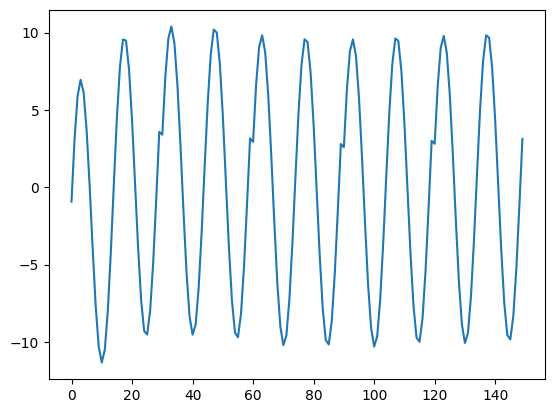

In [116]:
acausal_filter(data_buffer, filt_buffer, rev_buffer, sos, zi, group_list, rev_win, rev_zi)
_=plt.plot(rev_buffer[0])

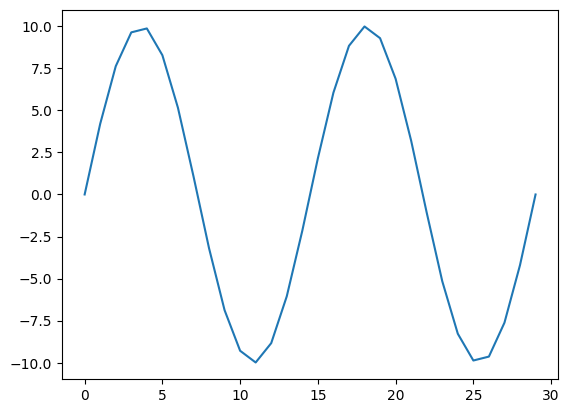

In [118]:
_=plt.plot(data_buffer[0])
# _=plt.plot(b[0])

In [104]:
a,zi[:, :] =scipy.signal.sosfilt(sos,data_buffer,axis=1,zi=zi)
b,zi[:, :] =scipy.signal.sosfilt(sos,a,axis=1,zi=zi)

In [ ]:
ic = rev_zi * filt_data[:, -1][None, :, None]
c = scipy.signal.sosfilt(sos,rev_buffer[:, ::-1],axis=1,zi=ic)[0][:, -n_samp:][:, ::-1]